In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import pearsonr

import IPython

sns.set(color_codes=True)
plt.style.use('seaborn')

import cvxpy
from tqdm import tqdm

In [2]:
def basis_pursuit(A, y):
    x = cvxpy.Variable(A.shape[1])
    objective = cvxpy.Minimize(cvxpy.sum_entries(cvxpy.abs(x)))
    constraints = [ A * x == y ]
    problem = cvxpy.Problem(objective, constraints)
    problem.solve()
    if problem.status == 'optimal':
        return np.array(x.value).reshape(-1)
    else:
        return None

In [3]:
def quadratically_constrained_basis_pursuit(A, y, eta=1e-3):
    x = cvxpy.Variable(A.shape[1])
    objective = cvxpy.Minimize(cvxpy.sum_entries(cvxpy.abs(x)))
    constraints = [ cvxpy.sum_entries(cvxpy.abs(A * x - y)) < eta ]
    problem = cvxpy.Problem(objective, constraints)
    problem.solve()
    if problem.status == 'optimal':
        return np.array(x.value).reshape(-1)
    else:
        return None

In [4]:
def compressed_sensing(k, m=500, measurement_samples=20, sparse_recovery_alg=basis_pursuit, sparse_recovery_args={}):
    filename = "../output/mnist_logreg_sensing_{}_{}.npz".format(k, m)
    data = np.load(filename)
    
    N = data['all_loss_diffs'].shape[0]
    x_hat = data['all_loss_diffs']
    y = data['actual_loss_diffs']
    indices_to_remove = data['indices_to_remove']
    
    A = np.zeros((m, N))
    for i in range(m):
        A[i][indices_to_remove[i]] = 1
    
    # Try using different numbers of measurements
    measurements = np.arange(m, 0, -max(m // measurement_samples, 1))
    # l1 dist between x_hat and recovered x
    error = np.zeros((len(measurements), 2))
    # l1 dist only between the top s indices of x by absolute value
    possible_s = [10, 20, 50, 100, 500]
    restricted_error = { s: np.zeros((len(measurements), 2)) for s in possible_s }
    
    for i, M in enumerate(measurements):
        x = sparse_recovery_alg(A[:M, :], y[:M], **sparse_recovery_args)
        error[i] = [ np.sum(np.abs(x - x_hat)), np.max(np.abs(x - x_hat)) ]
        
        x_sort = np.argsort(np.abs(x))
        for s, error_s in restricted_error.items():
            residual = np.abs(x[x_sort[-s:]] - x_hat[x_sort[-s:]])
            error_s[i] = [ np.sum(residual), np.max(residual) ]
    
    fig, axs = plt.subplots(2, 1, figsize=(16, 20))
    
    for i, metric in enumerate(['L1 error', 'Linf error']):
        axs[i].plot(measurements, error[:, i], marker='o',
                 label=metric)
        for s, error_s in restricted_error.items():
            axs[i].plot(measurements, error_s[:, i], marker='o',
                     label='Restricted {} (s = {})'.format(metric, s))
        axs[i].set_title("Sparse recovery {} with m={} measurements using size-k={} subsets".format(metric, m, k))
        axs[i].set_xlabel('measurements')
        axs[i].set_ylabel(metric)
        axs[i].legend()

In [5]:
def sparsity_defect(k, m=500, measurement_samples=20):
    filename = "../output/mnist_logreg_sensing_{}_{}.npz".format(k, m)
    data = np.load(filename)
    
    N = data['all_loss_diffs'].shape[0]
    x_hat = data['all_loss_diffs']
    y = data['actual_loss_diffs']
    indices_to_remove = data['indices_to_remove']
    
    A = np.zeros((m, N))
    for i in range(m):
        A[i][indices_to_remove[i]] = 1
    
    # Try using different numbers of measurements
    measurements = np.arange(m, 0, -max(m // measurement_samples, 1))
    # Sparsity defect if s = floor(M / 2)
    sparsity_defect = np.zeros(len(measurements))
    
    for i, M in enumerate(measurements):
        s = M // 2
        order = np.argsort(np.abs(x_hat))
        sparsity_defect[i] = np.sum(np.abs(x_hat[order[:-s]]))
    
    fig = plt.figure(figsize=(16, 10))
    
    plt.plot(measurements, sparsity_defect, marker='o')
    plt.title("Sparsity defect for s = measurements/2")
    plt.xlabel('measurements')
    plt.ylabel('Sparsity defect')

In [6]:
def sanity_check(k, m=500, restrict_N=5500, measurement_samples=20, sigma=0,
                 sparse_recovery_alg=basis_pursuit, sparse_recovery_args={}):
    filename = "../output/mnist_logreg_sensing_{}_{}.npz".format(k, m)
    data = np.load(filename)
    
    N = data['all_loss_diffs'].shape[0]
    x_hat = data['all_loss_diffs']
    y = data['actual_loss_diffs']
    
    x_hat = x_hat[:restrict_N]
    
    measurements = np.arange(restrict_N, 0, -max(restrict_N // (measurement_samples + 1), 1))[1:]
    gaussian_error = np.zeros((len(measurements), 2))
    bernoulli_error = np.zeros((len(measurements), 2))
    subsets_error = { restrict_N // k: np.zeros((len(measurements), 2)) for k in [100, 10, 5, 2] }
    
    def try_matrix(A, x_hat):
        y = np.dot(A, x_hat) + sigma * np.random.randn(A.shape[0])
        x = sparse_recovery_alg(A, y, **sparse_recovery_args)
        l1_error, linf_error = np.nan, np.nan
        if x is not None:
            l1_error = np.sum(np.abs(x - x_hat))
            linf_error = np.max(np.abs(x - x_hat))
        return [l1_error, linf_error]
    
    # Try different numbers of measurements
    pbar = tqdm(enumerate(measurements))
    for i, M in pbar:
        pbar.set_description("Trying {} measurements: {}".format(M, "gaussian"))
        # Pick a random Gaussian matrix
        A = np.random.randn(M, restrict_N)
        gaussian_error[i] = try_matrix(A, x_hat)
        
        pbar.set_description("Trying {} measurements: {}".format(M, "bernoulli"))
        # Pick a random Bernoulli matrix
        A = np.random.binomial(1, 0.5, (M, restrict_N)) * 2 - 1
        bernoulli_error[i] = try_matrix(A, x_hat)
        
        # Pick random small subsets
        for subset_size in subsets_error:
            pbar.set_description("Trying {} measurements: {}".format(M, "{}-subset".format(subset_size)))
            A = np.zeros((M, restrict_N))
            for j in range(M):
                indices = np.random.choice(restrict_N, subset_size)
                A[j][indices] = 1
            l1, linf = try_matrix(A, x_hat)
            subsets_error[subset_size][i] = try_matrix(A, x_hat)
    
    fig, axs = plt.subplots(2, 1, figsize=(16, 20))
    
    for i, metric in enumerate(['L1 error', 'Linf error']):
        axs[i].plot(measurements, gaussian_error[:, i], marker='o',
                 label='Gaussian matrix')
        axs[i].plot(measurements, bernoulli_error[:, i], marker='o',
                 label='Bernoulli matrix')
        for subset_size, error in subsets_error.items():
            axs[i].plot(measurements, error[:, i], marker='o',
                     label='random subsets of size k={}'.format(subset_size))
        if sigma == 0:
            axs[i].set_title(("Sparse recovery on N={} dataset"
                              + " with exact measurements").format(restrict_N))
        else:
            axs[i].set_title(("Sparse recovery on N={} dataset"
                              + " with Gaussian (sigma={}) noise").format(restrict_N, sigma))
        axs[i].set_xlabel('measurements')
        axs[i].set_ylabel(metric)
        axs[i].legend()

## Compressed Sensing test

Here's the test procedure: calculate the actual loss change (by retraining) for a few subsets of points removed, and try to recover the individual influences of training points. However, we need to keep the tested subsets small. Hence, we select some **k** for the size of subsets to try, then construct **A** as an **m** by **N** binary matrix of **m** measurements, where each row has a random set of **k** 1s. We train and retrain the model for each of these measurements, but use the HVP method to calculate the "ground truth" predicted influence for all the points.

To obtain the "recovered" influences, we solve the following problem:

_minimize_ **||x||<sub>1</sub>** _subject to_ **Ax = y**

We don't know if this works or how well it works, so we'll try this for different **k** and plot error against number of measurements used. We'll try the direct L1 error between the computed influences and the recovered influences, and also try to restrict the recovered influences to only the top **s** indices by absolute value (pretend it's sparse).

## Sanity check

Using the predicted loss on each training point, we simulate (exact) measurements using different random matrices and see how L1 minimization sparse recovery performs.

Trying 4 measurements: 275-subset: : 21it [02:27,  7.04s/it]  


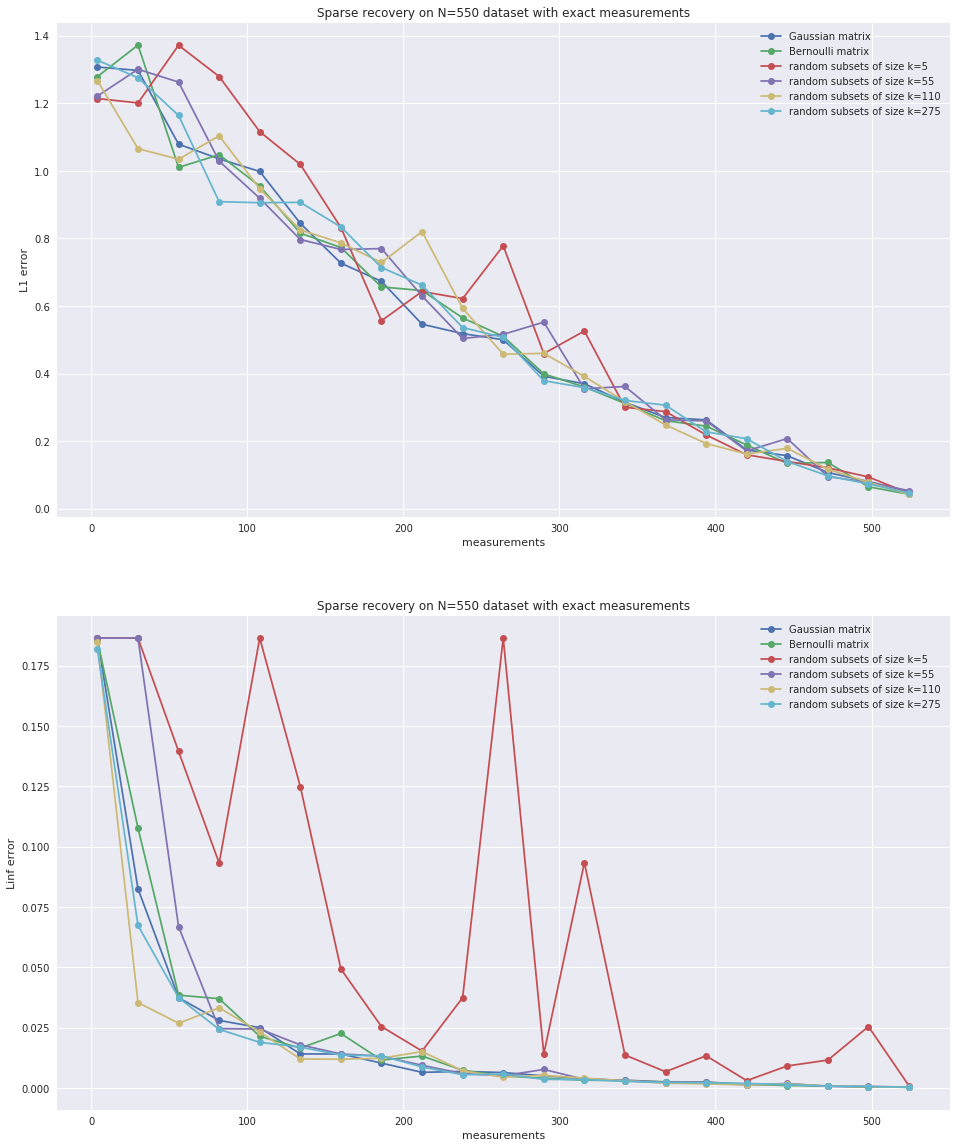

In [23]:
sanity_check(10, 500, restrict_N=550, measurement_samples=20)

Trying 4 measurements: 275-subset: : 21it [02:38,  7.54s/it]  


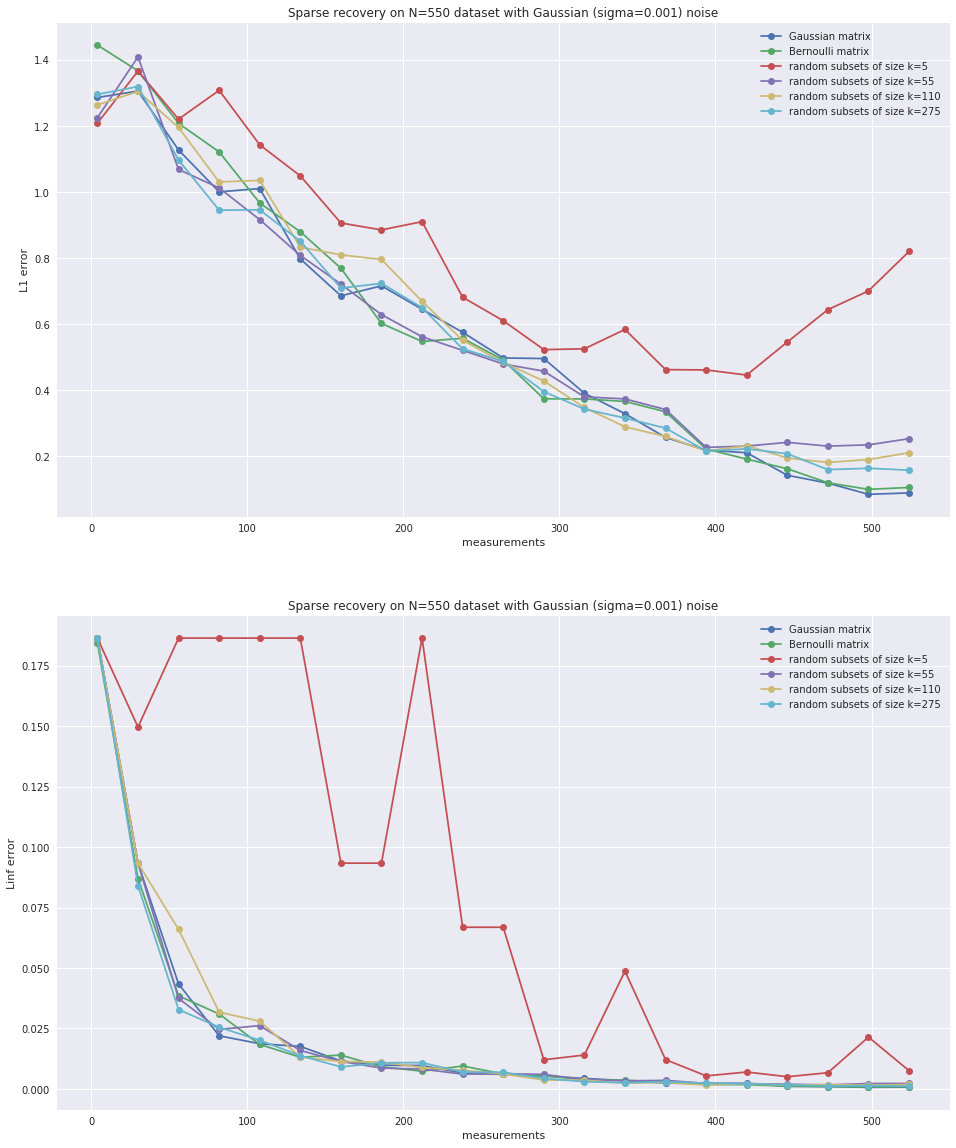

In [24]:
sanity_check(10, 500, restrict_N=550, measurement_samples=20, sigma=1e-3)

Trying 4 measurements: 275-subset: : 21it [02:22,  6.78s/it]  


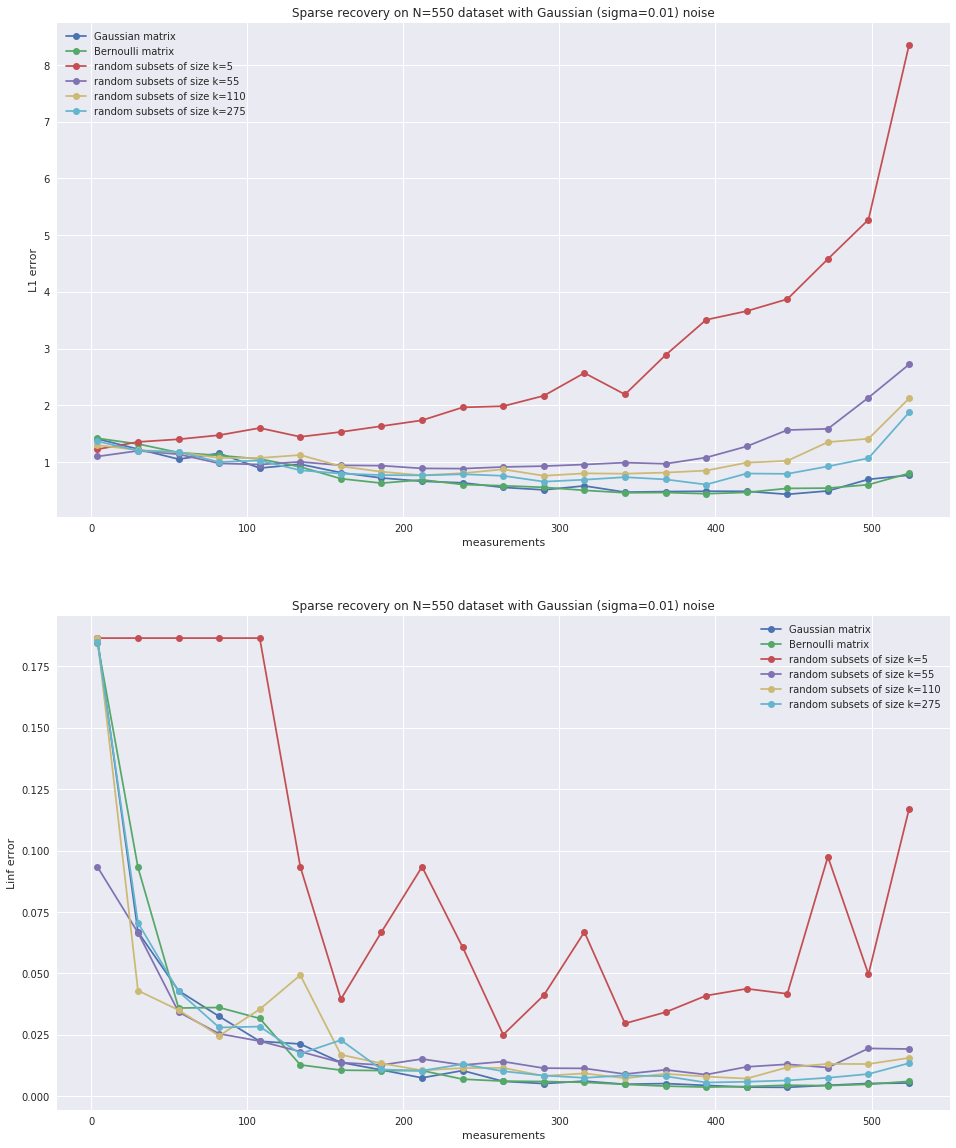

In [30]:
sanity_check(10, 500, restrict_N=550, measurement_samples=20, sigma=1e-2)

If we try using quadratically constrained basis pursuit with a tolerance far larger than the standard deviation of the noise added and see if it find a better solution, it doesn't seem to help.

Trying 4 measurements: 275-subset: : 21it [05:34, 15.91s/it]  


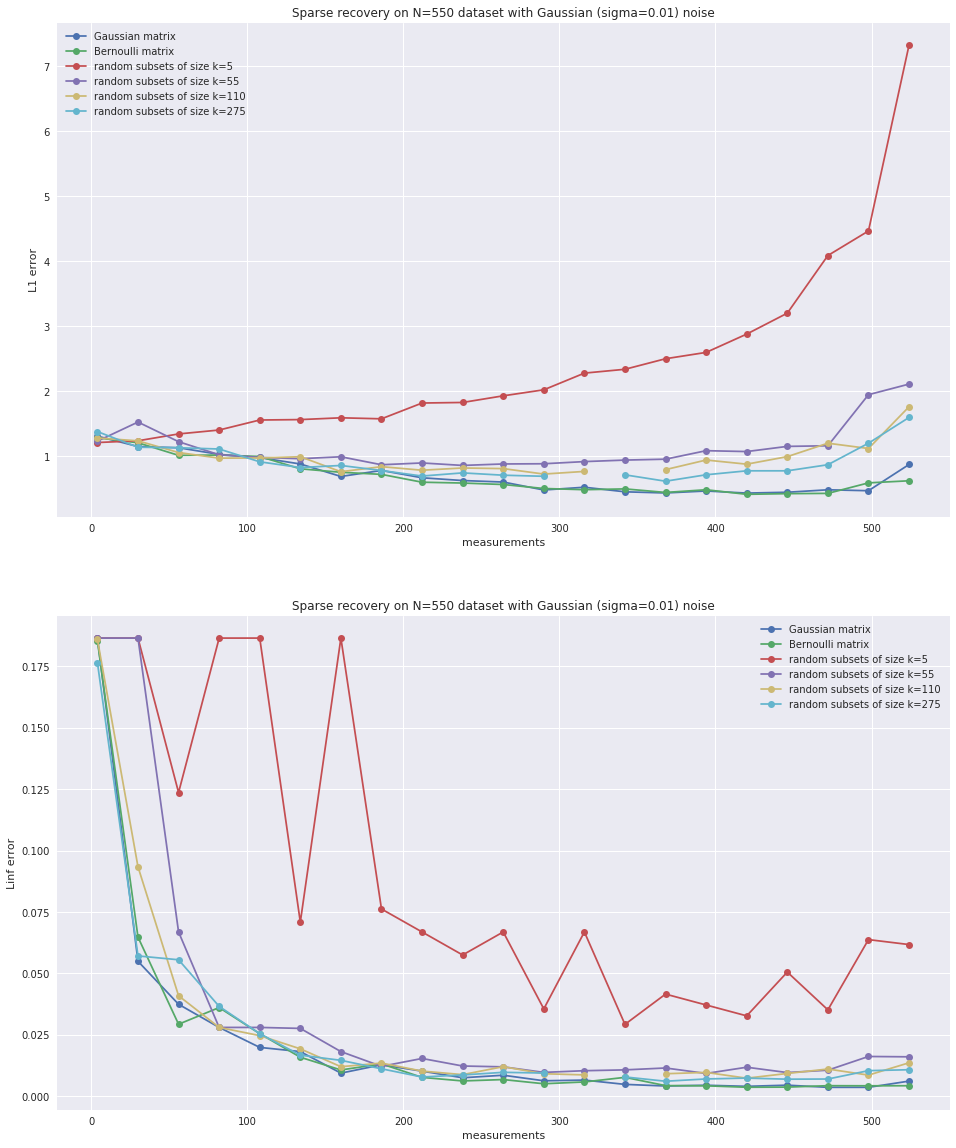

In [8]:
sanity_check(10, 500, restrict_N=550, measurement_samples=20, sigma=1e-2,
             sparse_recovery_alg=quadratically_constrained_basis_pursuit, sparse_recovery_args={'eta': 1e-1})

## Sparsity defect

The predicted influence should be the same for all of these sensing tests, so we only calculate the sparsity defect from one output file.

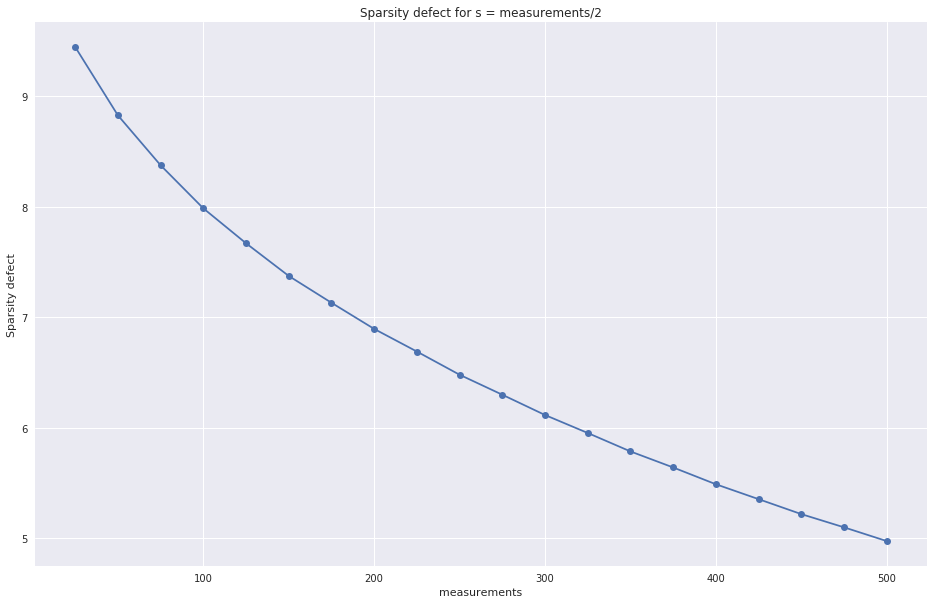

In [29]:
sparsity_defect(10, 500)

## Sparse recovery error

### k = 10

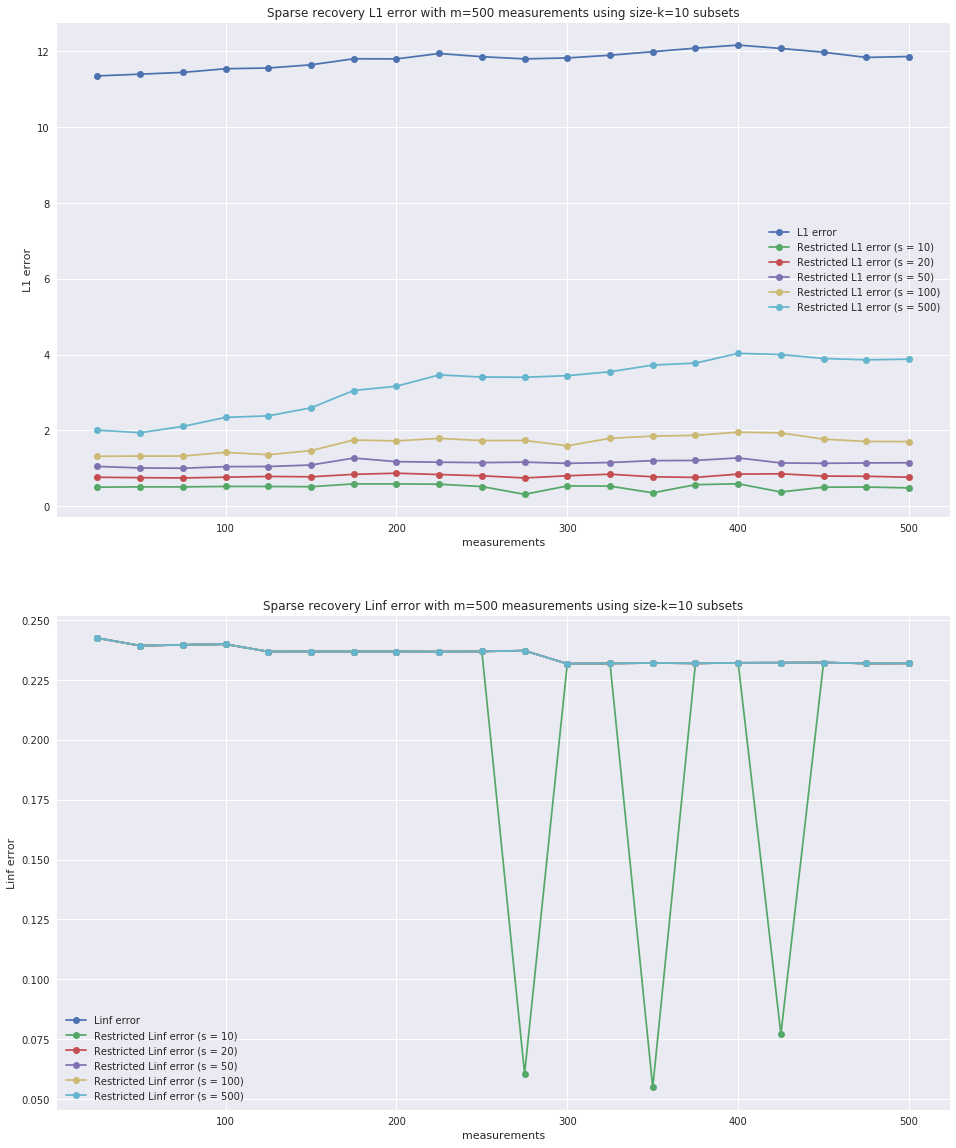

In [28]:
compressed_sensing(10, 500)

### k = 100

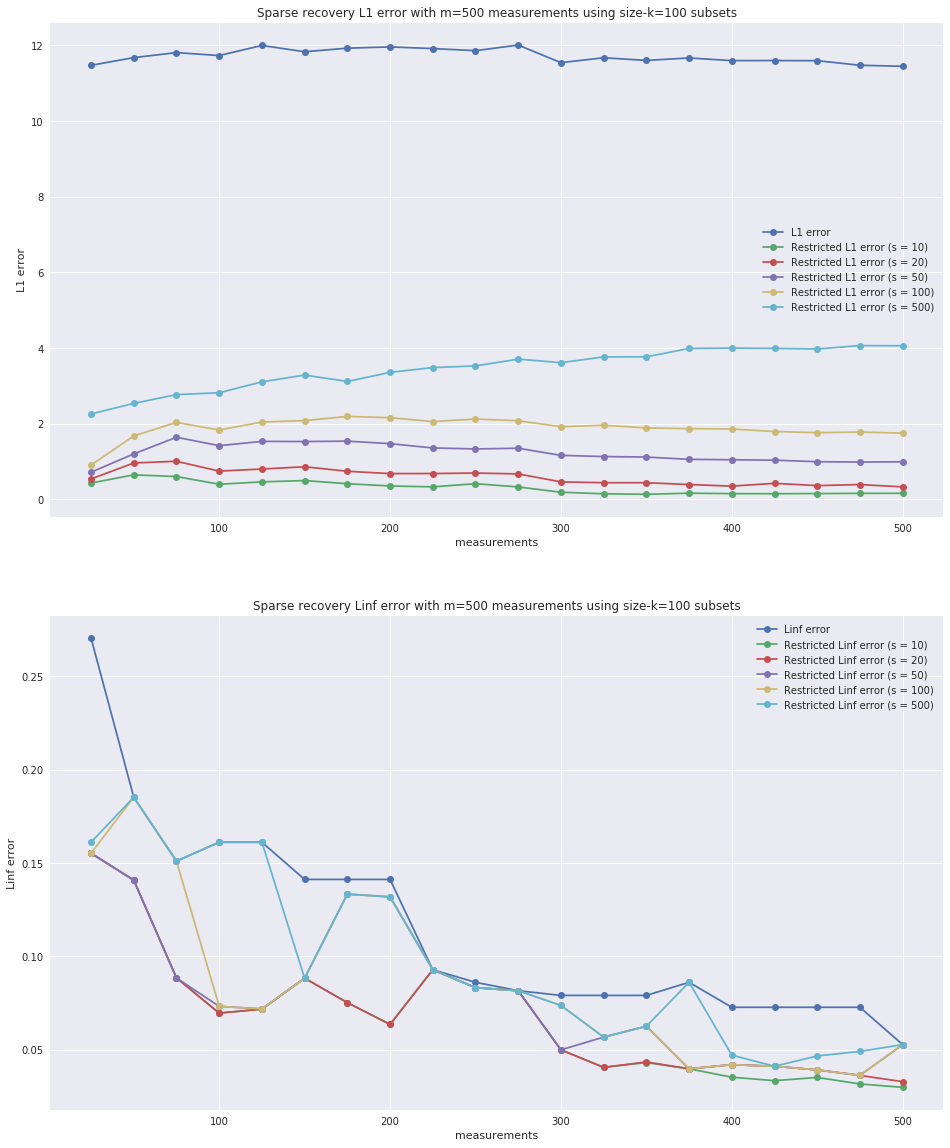

In [31]:
compressed_sensing(100, 500)

### k = 500

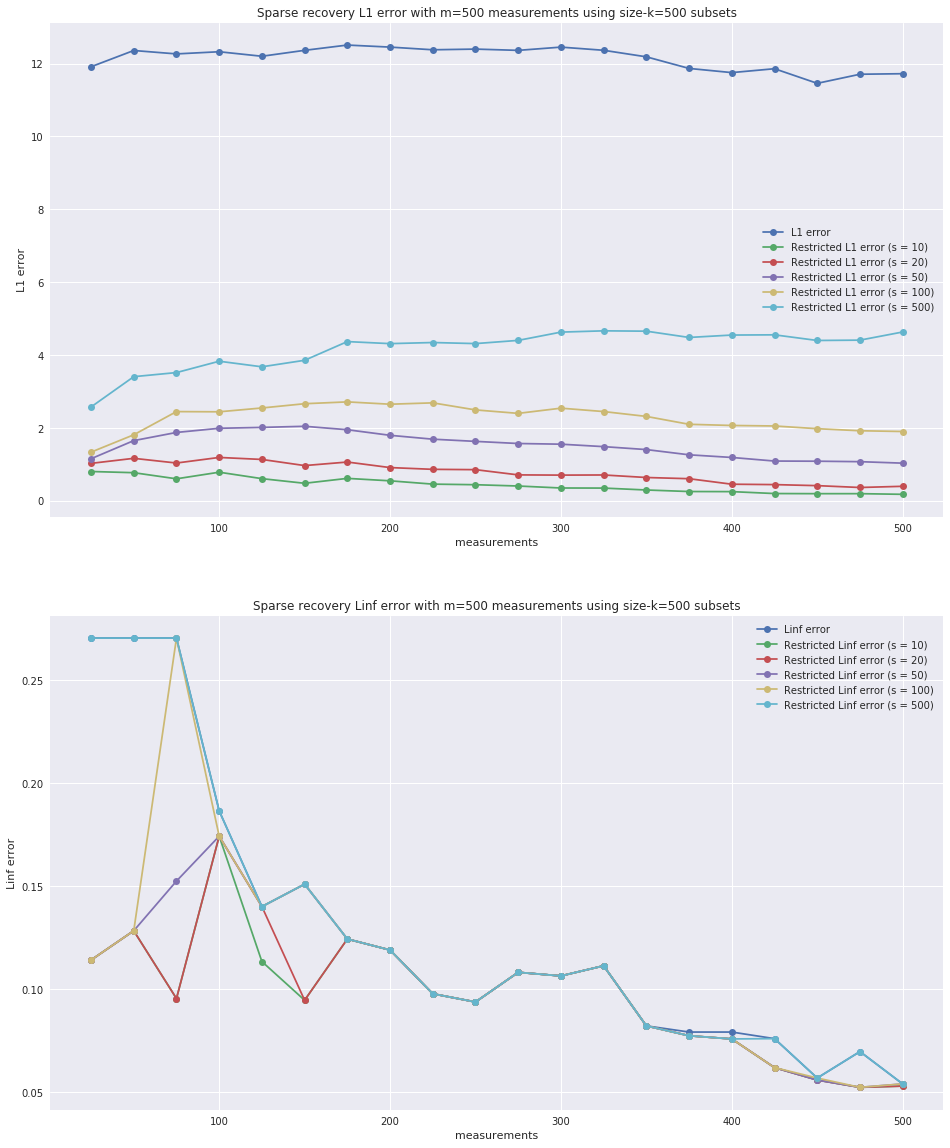

In [32]:
compressed_sensing(500, 500)

Try performing sparse recovery with non-binary easurement matrices. This requires changing the code to accept training weights.